In [1]:
!python -c "import monai" || pip install -q "monai-weekly[nibabel, tqdm]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

In [2]:
"""
0: background,
1: sacrum,
2: right_hip,
3: left_hip,
4: lumbar_vertebra.        
"""        

'\n0: background,\n1: sacrum,\n2: right_hip,\n3: left_hip,\n4: lumbar_vertebra.        \n'

In [3]:
from monai.utils import first, set_determinism
from monai.transforms import (
    AddChanneld,
    AsDiscrete,
    AsDiscreted,
    EnsureChannelFirstd,
    Compose,
    Resized,
    CropForegroundd,
    RandScaleIntensityd,
    DataStatsd,
    LoadImaged,
    Orientationd,
    Activationsd,
    RandCropByPosNegLabeld,
    RandShiftIntensityd,
    NormalizeIntensityd,
    RandSpatialCropd,
    ScaleIntensityRanged,
    Spacingd,
    ScaleIntensityd,
    SaveImaged,
    EnsureTyped,
    EnsureType,
    Invertd,
)
from monai.handlers.utils import from_engine
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
from monai.config import print_config
from monai.apps import download_and_extract
import torch
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
import glob
from monai.optimizers import Novograd
from monai.utils import get_torch_version_tuple, set_determinism
from ignite.handlers import EarlyStopping, ModelCheckpoint

print_config()


MONAI version: 0.9.dev2209
Numpy version: 1.21.5
Pytorch version: 1.10.2
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: 9db6e543d6090a3256f20695c1d3224df8cbbc0e
MONAI __file__: C:\Users\Hripsime\anaconda3\envs\abys\lib\site-packages\monai\__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.8
Nibabel version: 3.2.2
scikit-image version: 0.19.2
Pillow version: 9.0.1
Tensorboard version: 2.8.0
gdown version: 4.2.1
TorchVision version: 0.11.3
tqdm version: 4.63.0
lmdb version: 1.3.0
psutil version: 5.9.0
pandas version: 1.4.1
einops version: 0.4.0
transformers version: 4.16.2
mlflow version: 1.23.1

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



## Setup data directory

In [4]:
root_dir  = '../projects/CTPelvic1K_data/'

data_image = os.path.join(root_dir, 'images')
data_mask = os.path.join(root_dir, 'masks')


## Set dataset path

In [5]:
train_images = sorted(glob.glob(os.path.join(data_image, "*data.nii.gz")))
train_labels = sorted(glob.glob(os.path.join(data_mask, "*mask_4label.nii.gz")))

data_dicts = [ {"image": image_name, "mask": label_name} for image_name, label_name in zip(train_images, train_labels) ]
train_files, val_files = data_dicts[:-10], data_dicts[-10:]

In [6]:
set_determinism(seed=0)

In [7]:
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "mask"]),
        EnsureChannelFirstd(keys=["image", "mask"]),
        Orientationd(keys=["image", "mask"], axcodes="RAS"),
        Spacingd(keys=["image", "mask"], pixdim=(1.0, 1.0, 1.0), mode=("bilinear", "nearest")),
        CropForegroundd(keys=["image", "mask"], source_key="image"),
        ScaleIntensityRanged(keys=["image"], a_min=-120, a_max=360, b_min=0.0, b_max=1.0, clip=True,),
        #DataStatsd(keys=["image", "mask"], prefix='Data', data_type=True, data_shape=True, value_range=True, data_value=False),
        
        RandCropByPosNegLabeld(
            keys=["image", "mask"],
            label_key="mask",
            spatial_size=(128, 128, 128),
            pos=1,
            neg=1,
            num_samples=4,
            image_key="image",
            image_threshold=0,),
            
        EnsureTyped(keys=["image", "mask"]),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "mask"]),
        EnsureChannelFirstd(keys=["image", "mask"]),
        Orientationd(keys=["image", "mask"], axcodes="RAS"),
        Spacingd(keys=["image", "mask"], pixdim=(1.0, 1.0, 1.0), mode=("bilinear", "nearest")),
        ScaleIntensityRanged(keys=["image"], a_min=-120, a_max=360, b_min=0.0, b_max=1.0, clip=True,),
        CropForegroundd(keys=["image", "mask"], source_key="image"),
        
        EnsureTyped(keys=["image", "mask"]),
    ]
)



In [8]:
train_ds = CacheDataset(data=train_files, transform=train_transforms, cache_rate=1.0, num_workers=0)
train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=0)

val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_rate=1.0, num_workers=0)
val_loader = DataLoader(val_ds, batch_size=1, num_workers=0)


Loading dataset: 100%|█████████████████████████████████████████████████████████████████| 10/10 [01:30<00:00,  9.07s/it]


In [9]:
check_ds = Dataset(data=val_files, transform=val_transforms)
check_loader = DataLoader(check_ds, batch_size=1)
check_data = first(check_loader)
image, label = (check_data["image"][0][0], check_data["mask"][0][0])
print(f"image shape: {image.shape}, mask shape: {label.shape}")

image shape: torch.Size([372, 234, 261]), mask shape: torch.Size([372, 234, 261])


In [10]:
from monai.visualize import blend_images, matshow3d, plot_2d_or_3d_image
ret = blend_images(image=check_data["image"][0], label=check_data["mask"][0], alpha=0.5, cmap="hsv", rescale_arrays=False)
print(ret.shape)

torch.Size([3, 372, 234, 261])


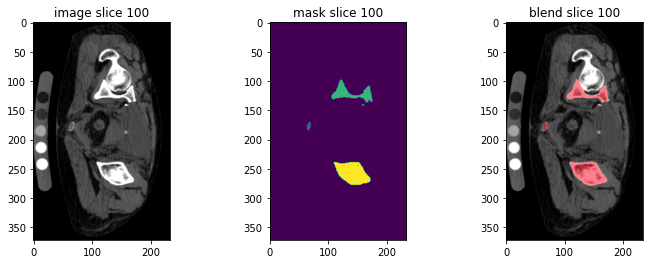

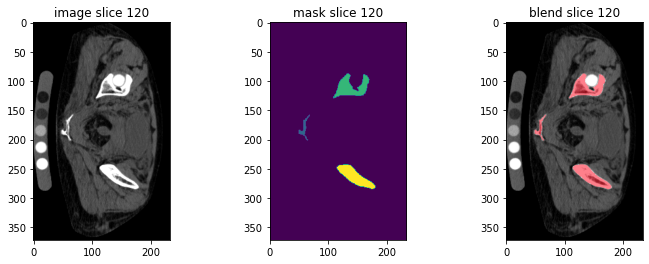

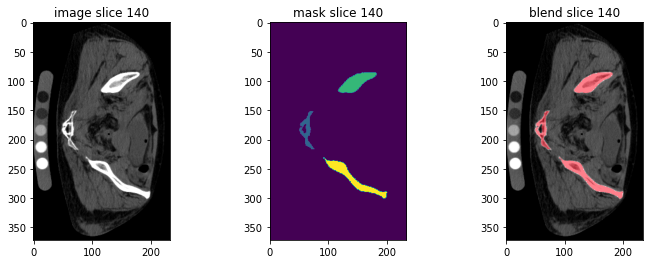

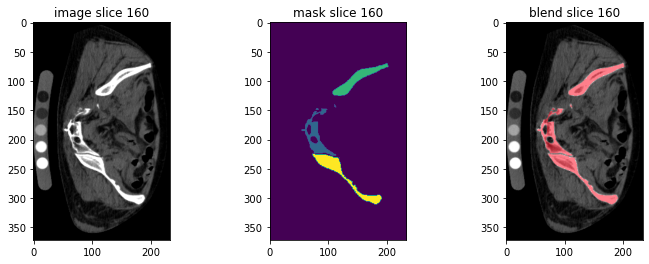

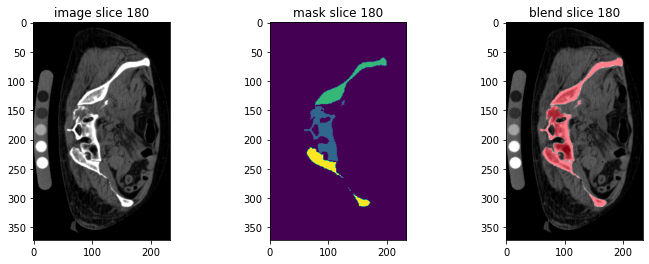

In [11]:
for i in range(5, 10):
    # plot the slice 50 - 100 of image, label and blend result
    slice_index = 20 * i
    plt.figure("blend image and mask", (12, 4))
    plt.subplot(1, 3, 1)
    plt.title(f"image slice {slice_index}")
    plt.imshow(check_data["image"][0, 0, :, :, slice_index], cmap="gray")
    plt.subplot(1, 3, 2)
    plt.title(f"mask slice {slice_index}")
    plt.imshow(check_data["mask"][0, 0, :, :, slice_index])
    plt.subplot(1, 3, 3)
    plt.title(f"blend slice {slice_index}")
    # switch the channel dim to the last dim
    plt.imshow(torch.moveaxis(ret[:, :, :, slice_index], 0, -1))
    plt.show()

## Create Model, Loss, Optimizer

In [12]:
# standard PyTorch program style: create UNet, DiceLoss and Adam optimizer

VAL_AMP = True #Automatic mixed precision to accelerate training speed and reduce a memory usage
learning_rate = 2e-4

device=torch.device("cuda:0")     
#device=torch.device("cpu")      
model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=5,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
    norm=Norm.BATCH,
).to(device)

loss_function = DiceLoss(to_onehot_y=True, softmax=True)
#loss_function = DiceCELoss(to_onehot_y=True, softmax=True, squared_pred=True, batch=True) 

optimizer = torch.optim.Adam(model.parameters(), learning_rate)
#optimizer = Novograd(model.parameters(), learning_rate * 10)
dice_metric = DiceMetric(include_background=False, reduction="mean")


# define inference method
def inference(input):

    def _compute(input):
        return sliding_window_inference(
            inputs=input,
            roi_size=(160, 160, 160),
            sw_batch_size=4,
            predictor=model,
            overlap=0.5,
        )

    if VAL_AMP:
        with torch.cuda.amp.autocast():
            return _compute(input)
    else:
        return _compute(input)
    
# use amp to accelerate training
scaler = torch.cuda.amp.GradScaler()
# enable cuDNN benchmark
torch.backends.cudnn.benchmark = True    

In [13]:
# from pytorchtools import EarlyStopping
# early_stopping = EarlyStopping(patience=20, verbose=True)
# early stopping patience; how long to wait after last time validation loss improved.

## Execute a typical PyTorch training process

In [14]:
max_epochs = 30
val_interval = 1
best_metric = -1
best_metric_epoch = -1

epoch_loss_values = []
metric_values = []
post_pred = Compose([EnsureType(), AsDiscrete(argmax=True, to_onehot=5)])
post_label = Compose([EnsureType(), AsDiscrete(to_onehot=5)])

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["mask"].to(device),
        )
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        epoch_loss += loss.item()
        print(
            f"{step}/{len(train_ds) // train_loader.batch_size}, "
            f"train_loss: {loss.item():.4f}")
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        
        model.eval()
        with torch.no_grad():
            for val_data in val_loader:
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["mask"].to(device),
                )
                
                val_outputs = inference(val_inputs)
                val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
                val_labels = [post_label(i) for i in decollate_batch(val_labels)]
                
                # compute metric for current iteration
                dice_metric(y_pred=val_outputs, y=val_labels)

            # aggregate the final mean dice result
            metric = dice_metric.aggregate().item()
            
            # reset the status for next validation round
            dice_metric.reset()

            metric_values.append(metric)
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(root_dir, "best_metric_model.pth"))
                print("saved new best metric model")
            
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f"\nbest mean dice: {best_metric:.4f} "
                f"at epoch: {best_metric_epoch}"
            )

----------
epoch 1/30
1/15, train_loss: 0.9016
2/15, train_loss: 0.8923
3/15, train_loss: 0.8992
4/15, train_loss: 0.8899
5/15, train_loss: 0.8853
6/15, train_loss: 0.8775
7/15, train_loss: 0.8775
8/15, train_loss: 0.8861
9/15, train_loss: 0.8747
10/15, train_loss: 0.8736
11/15, train_loss: 0.8661
12/15, train_loss: 0.8557
13/15, train_loss: 0.8742
14/15, train_loss: 0.8635
15/15, train_loss: 0.8669
16/15, train_loss: 0.8548
epoch 1 average loss: 0.8774
saved new best metric model
current epoch: 1 current mean dice: 0.1066
best mean dice: 0.1066 at epoch: 1
----------
epoch 2/30
1/15, train_loss: 0.8605
2/15, train_loss: 0.8701
3/15, train_loss: 0.8504
4/15, train_loss: 0.8712
5/15, train_loss: 0.8550
6/15, train_loss: 0.8576
7/15, train_loss: 0.8566
8/15, train_loss: 0.8498
9/15, train_loss: 0.8532
10/15, train_loss: 0.8536
11/15, train_loss: 0.8432
12/15, train_loss: 0.8528
13/15, train_loss: 0.8279
14/15, train_loss: 0.8151
15/15, train_loss: 0.8365
16/15, train_loss: 0.8101
epoch 2

16/15, train_loss: 0.5762
epoch 15 average loss: 0.6047
saved new best metric model
current epoch: 15 current mean dice: 0.5418
best mean dice: 0.5418 at epoch: 15
----------
epoch 16/30
1/15, train_loss: 0.6448
2/15, train_loss: 0.5812
3/15, train_loss: 0.6365
4/15, train_loss: 0.5557
5/15, train_loss: 0.5119
6/15, train_loss: 0.5715
7/15, train_loss: 0.6163
8/15, train_loss: 0.5626
9/15, train_loss: 0.5410
10/15, train_loss: 0.6292
11/15, train_loss: 0.6520
12/15, train_loss: 0.5323
13/15, train_loss: 0.5281
14/15, train_loss: 0.5285
15/15, train_loss: 0.5732
16/15, train_loss: 0.5827
epoch 16 average loss: 0.5780
saved new best metric model
current epoch: 16 current mean dice: 0.5902
best mean dice: 0.5902 at epoch: 16
----------
epoch 17/30
1/15, train_loss: 0.6763
2/15, train_loss: 0.5015
3/15, train_loss: 0.5696
4/15, train_loss: 0.6088
5/15, train_loss: 0.5757
6/15, train_loss: 0.6020
7/15, train_loss: 0.5543
8/15, train_loss: 0.5884
9/15, train_loss: 0.5515
10/15, train_loss: 0

11/15, train_loss: 0.5433
12/15, train_loss: 0.4637
13/15, train_loss: 0.3564
14/15, train_loss: 0.4928
15/15, train_loss: 0.4890
16/15, train_loss: 0.5291
epoch 30 average loss: 0.4634
saved new best metric model
current epoch: 30 current mean dice: 0.7479
best mean dice: 0.7479 at epoch: 30


In [15]:
print(
    f"train completed, best_metric: {best_metric:.4f} "
    f"at epoch: {best_metric_epoch}")

train completed, best_metric: 0.7479 at epoch: 30


## Evaluation of Model on testing dataset

In [16]:
import gc #garbage collector
gc.collect()
torch.cuda.empty_cache()
torch.cuda.synchronize()

In [17]:
test_image = os.path.join(root_dir, 'test_images')
test_mask = os.path.join(root_dir, 'test_masks')

In [18]:
test_images = sorted(glob.glob(os.path.join(test_image, "*data.nii.gz")))
test_labels = sorted(glob.glob(os.path.join(test_mask , "*mask_4label.nii.gz")))

test_dicts = [ {"image": image_name, "mask": label_name} for image_name, label_name in zip(test_images, test_labels) ]
test_files = test_dicts[:]

In [19]:
test_transforms = Compose(
    [
        LoadImaged(keys=["image", "mask"]),
        EnsureChannelFirstd(keys=["image", "mask"]),
        Orientationd(keys=["image"], axcodes="RAS"),
        Spacingd(keys=["image"], pixdim=(
            1.0, 1.0, 1.0), mode="bilinear"),
        ScaleIntensityRanged(
            keys=["image"], a_min=-120, a_max=360,
            b_min=0.0, b_max=1.0, clip=True,
        ),
        CropForegroundd(keys=["image"], source_key="image"),
        EnsureTyped(keys=["image", "mask"]),
    ]
)

In [20]:
test_ds = Dataset(data=test_files, transform=test_transforms)
test_loader  = DataLoader(test_ds, batch_size=1, num_workers=0)

# test_ds = CacheDataset(data=test_files, transform=test_transforms, cache_rate=1.0, num_workers=0)
# test_loader = DataLoader(test_ds, batch_size=1, num_workers=0)

In [21]:
post_transforms = Compose([
    EnsureTyped(keys="pred"),
    
    Invertd(
        keys="pred",
        transform=test_transforms,
        orig_keys="image",
        meta_keys="pred_meta_dict",
        orig_meta_keys="image_meta_dict",
        meta_key_postfix="meta_dict",
        nearest_interp=False,
        to_tensor=True,
    ),
    
    AsDiscreted(keys="pred", argmax=True, to_onehot=5),
    AsDiscreted(keys="mask", to_onehot=5),
    
])

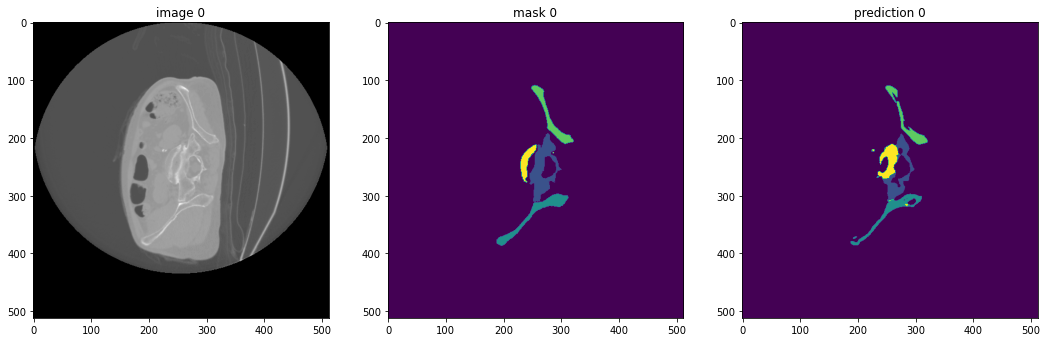

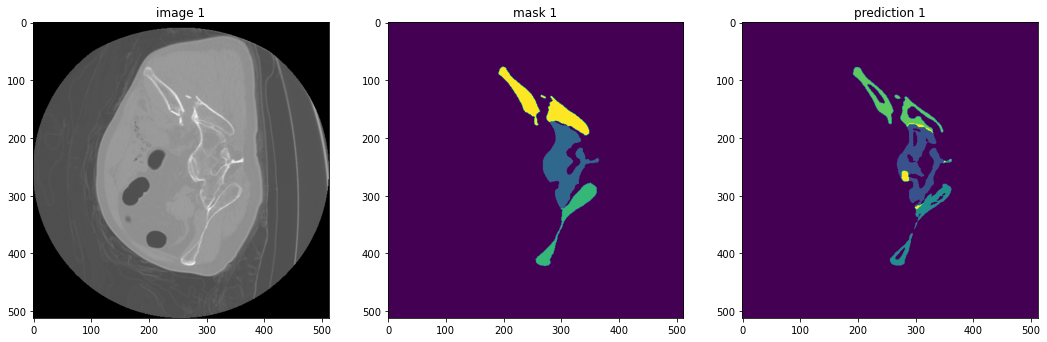

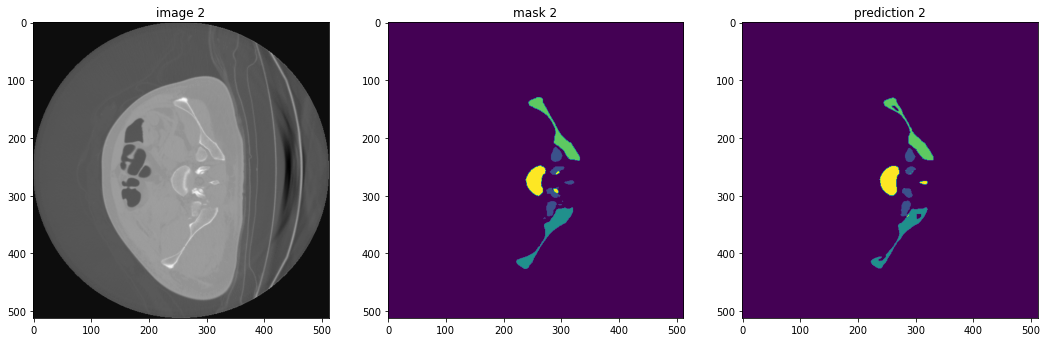

In [22]:
from monai.transforms import LoadImage
loader = LoadImage()

model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))
model.eval()

with torch.no_grad():
    for i, test_data in enumerate(test_loader):
        test_inputs = test_data["image"].to(device)
        roi_size = (160, 160, 160)
        sw_batch_size = 4
        test_data["pred"] = sliding_window_inference(test_inputs, roi_size, sw_batch_size, model,sw_device="cuda:0", device="cpu")
        test_data = [post_transforms(i) for i in decollate_batch(test_data)]
        test_outputs, test_labels = from_engine(["pred", "mask"])(test_data)
        original_image = loader(test_data[0]["image_meta_dict"]["filename_or_obj"])[0]
        
        plt.figure("check", (18, 6))
        plt.subplot(1, 3, 1)
        plt.title(f"image {i}")
        plt.imshow(original_image[:, :, 250], cmap="gray")
        plt.subplot(1, 3, 2)
        plt.title(f"mask {i}")
        plt.imshow(torch.argmax(test_labels[0], dim=0).detach().cpu()[:, :, 250])
        plt.subplot(1, 3, 3)
        plt.title(f"prediction {i}")
        plt.imshow(torch.argmax(test_outputs[0], dim=0).detach().cpu()[:, :, 250])
        plt.show()
        if i == 2:
            break

In [23]:
type(original_image)

numpy.ndarray

In [25]:
type(test_outputs[0])

torch.Tensor

In [30]:
from monai.visualize import blend_images, matshow3d, plot_2d_or_3d_image

rety = blend_images(image=original_image, label=test_outputs[0], alpha=0.5, cmap="hsv", rescale_arrays=False)
print(rety.shape)

ValueError: Label should have 1 channel

NameError: name 'rety' is not defined

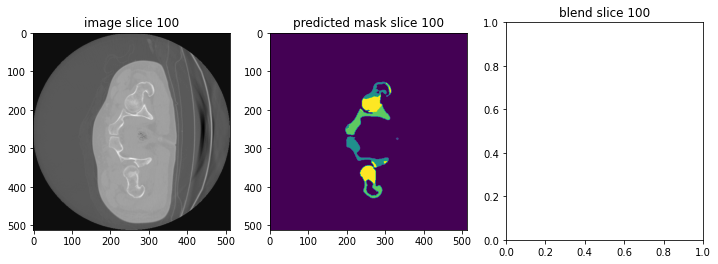

In [31]:
for i in range(5, 10):
    
    slice_index = 20 * i
    plt.figure("blend image and mask", (12, 4))
    plt.subplot(1, 3, 1)
    plt.title(f"image slice {slice_index}")
    plt.imshow(original_image[:, :, slice_index], cmap="gray")
    plt.subplot(1, 3, 2)
    plt.title(f"predicted mask slice {slice_index}")
    plt.imshow(torch.argmax(test_outputs[0], dim=0).detach().cpu()[:, :, slice_index])
    plt.subplot(1, 3, 3)
    plt.title(f"blend slice {slice_index}")
    # switch the channel dim to the last dim
    plt.imshow(torch.moveaxis(rety[:, :, :, slice_index], 0, -1))
    plt.show()